<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#現状把握" data-toc-modified-id="現状把握-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>現状把握</a></span></li><li><span><a href="#データ取得" data-toc-modified-id="データ取得-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>データ取得</a></span></li><li><span><a href="#RVMモデルの作成" data-toc-modified-id="RVMモデルの作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>RVMモデルの作成</a></span></li><li><span><a href="#学習" data-toc-modified-id="学習-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>学習</a></span></li><li><span><a href="#学習結果" data-toc-modified-id="学習結果-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>学習結果</a></span></li><li><span><a href="#予測結果" data-toc-modified-id="予測結果-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>予測結果</a></span></li></ul></div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

# 現状把握

In [2]:
year = 2018
lst_of_df_2018 = []
print("year : ", year)
for league in ['p', 'c']:
    url = 'http://npb.jp/bis/'+str(year)+'/stats/tmb_'+league+'.html'
    lst_of_df_2018.append(pd.read_html(url, header=0)[0])
        
df_2018 = pd.concat(lst_of_df_2018).reset_index(drop=True)


# カラム名変更# カラム名変更
df_2018.columns = list(map(lambda v : v.replace("\u3000", ""), df_2018.columns))
# チーム名変更
df_2018['チーム'] = list(map(lambda v : v.replace("\u3000", "").replace(" ", ""), df_2018['チーム']))

df_2018 = df_2018.set_index("チーム").apply(pd.to_numeric)

df_2018['得点(1試合あたり)'] = df_2018['得点'] / df_2018['試合']

df_2018[[
    '打率',
    '出塁率',
    '長打率',
    '得点', 
    '得点(1試合あたり)'
]].sort_values(by='打率', ascending=False)

year :  2018


,打率,出塁率,長打率,得点,得点(1試合あたり)
チーム,,,,,
西武,0.284,0.364,0.446,212,5.888889
巨人,0.275,0.355,0.406,181,4.891892
広島,0.259,0.350,0.421,177,4.916667
中日,0.257,0.321,0.369,149,4.027027
ヤクルト,0.252,0.349,0.388,161,4.472222
ソフトバンク,0.251,0.317,0.430,154,4.400000
ロッテ,0.246,0.326,0.350,147,4.200000
DeNA,0.240,0.293,0.378,126,3.705882
日本ハム,0.231,0.314,0.382,136,3.675676


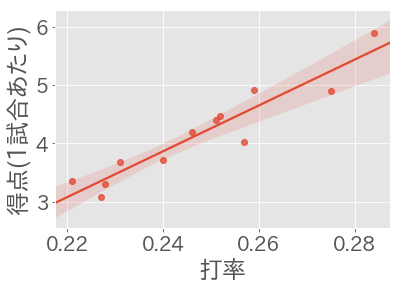

In [3]:
sns.regplot(x='打率', y='得点(1試合あたり)', data=df_2018)

この時点で、打率の上に結構乗っているんだよな。  
世間は、このような図を見て、「チーム打率が高いほどチーム得点は多い」と思いこんでしまっている。  
でもそれは嘘だ、という話をします。

# データ取得

In [4]:
yrange = range(2005, 2017 + 1)

lst_of_df = []
for year in yrange:
    print("year : ", year)
    for league in ['p', 'c']:
        url = 'http://npb.jp/bis/'+str(year)+'/stats/tmb_'+league+'.html'
        lst_of_df.append(pd.read_html(url, header=0)[0])

df = pd.concat(lst_of_df).set_index("チーム").apply(pd.to_numeric).reset_index()


# カラム名変更# カラム名変更
df.columns = list(map(lambda v : v.replace("\u3000", ""), df.columns))
# チーム名変更
df['チーム'] = list(map(lambda v : v.replace("\u3000", "").replace(" ", ""), df['チーム']))

df.loc[df['チーム'] == '横浜', 'チーム'] = '横浜(DeNA)'
df.loc[df['チーム'] == 'DeNA', 'チーム'] = '横浜(DeNA)'

df.head()

year :  2005
year :  2006
year :  2007
year :  2008
year :  2009
year :  2010
year :  2011
year :  2012
year :  2013
year :  2014
year :  2015
year :  2016
year :  2017


,チーム,打率,試合,打席,打数,得点,安打,二塁打,三塁打,本塁打,...,盗塁刺,犠打,犠飛,四球,故意四,死球,三振,併殺打,長打率,出塁率
0,ロッテ,0.282,136,5313,4730,740,1336,278,34,143,...,48,56,39,438,13,50,902,93,0.446,0.347
1,ソフトバンク,0.281,136,5181,4624,658,1300,225,23,172,...,42,86,36,356,22,77,818,114,0.451,0.340
2,西武,0.269,136,5215,4611,604,1240,234,18,162,...,28,88,26,437,35,52,926,112,0.433,0.337
3,オリックス,0.260,136,5166,4616,527,1202,202,17,97,...,26,97,32,376,10,45,835,93,0.375,0.320
4,楽天,0.255,136,5068,4577,504,1166,209,16,88,...,34,70,30,347,5,44,919,124,0.365,0.312


# RVMモデルの作成

In [5]:
def mean_squared_error(y, t):
    return np.mean((y - t)**2)

def rmse(y, t):
    return np.sqrt(np.mean((y - t) ** 2))

In [6]:
from abc import ABCMeta, abstractmethod

class MachineLearningModel(metaclass=ABCMeta):
    @abstractmethod
    def fit(self, data, target, **kwargs):
        # モデルの学習関数
        pass

    @abstractmethod
    def predict(self, data, **kwargs):
        # モデルの予測関数
        pass

    
class RegressionModel(MachineLearningModel):
    """
    回帰モデル。GLMでいうところの、「指数型分布:ガウス分布」に対応するモデル。
    """

    @abstractmethod
    def _forward(self, data):
        pass

    def predict(self, data):
        return self._forward(data)

    def rmse(self, data, target):
        # 第2引数であるargsは完全に無視される。
        # TwoLayerNetのモニタ関数であるaccuracy関数と引数の数を合わせるため。
        y = self.predict(data)
        return rmse(y, target)

    def loss(self, data, target):
        y = self.predict(data)
        return mean_squared_error(y, target)

In [7]:
class RelevanceVectorMachine(RegressionModel):
    def __init__(self, initial_alpha=1e-2, initial_beta=1e-2):
        self.alpha = initial_alpha
        self.beta = initial_beta
        self.inf = 1e10  # この値より大きくなったら、無限大とみなす。
        self.Cov = None
        self.m = None
        self.bool_arr_for_pred = None
        self.Phi = None
        self.M = None
        self._PhiTPhi = None
        self.itr = None

    def _update_mean_and_cov(self, target):
        A = np.diag(self.alpha)
        self.Cov = np.linalg.inv(A + self.beta * self._PhiTPhi)
        self.m = self.beta * self.Cov @ self.Phi.T @ target

    def _update_alphabeta(self, target, N):
        gamma = 1 - self.alpha * np.diag(self.Cov)
        self.beta = (N - np.sum(gamma)) / \
            np.sum((target - self.Phi @ self.m)**2)

        self.alpha = gamma / (self.m ** 2)

    def _remove_inf(self, verbose):
        """

        alphaが無限大に飛んだときそこに対応する特徴量を削減する

        """

        bool_arr = self.alpha <= self.inf
        if np.sum(bool_arr) == self.M:
            # どのalphaも無限大に飛ばなかったとき、そのまま
            return

        # 無限大に飛ばなかったものだけを残す
        self.alpha = self.alpha[bool_arr]
        self.Phi = self.Phi.T[bool_arr].T
        self.Cov = self.Cov[bool_arr].T[bool_arr].T
        self._PhiTPhi = self.Phi.T @ self.Phi
        self.m = self.m[bool_arr]

        # 予測のためのbool_arrをかきなおす。
        # bool_arrは、無限に飛んだ特徴量が出るたびにsizeが小さくなってしまうので、
        # 新規にデータに対して予測を行うために、
        # sizeが維持された配列をもうひとつ用意する必要がある。それがbool_arr_for_pred
        assert len(bool_arr) == np.sum(self.bool_arr_for_pred)
        # where : bool_arr_for_predの中で、未だにTrueである要素のインデックス
        where = np.where(self.bool_arr_for_pred)[0]

        # for i in range(self.M):
        #     if not bool_arr[i]:
        #         self.bool_arr_for_pred[where[i]] = False
        #         if verbose:
        #             print(where[i], "番目の要素が削除されました")
        # 上記のfor loopありのコードを最適化すると以下のとおりになる。
        ind = where[np.arange(self.M)[np.logical_not(bool_arr)]]
        self.bool_arr_for_pred[ind] = False
        if verbose:
            for i in ind:
                print(i, "番目の要素が削除されました")

        self.M = np.sum(bool_arr).astype(int)

    def fit(self, data, target, patience=1e-4, random_state=None, verbose=False):
        """
        Nがデータ数。
        self.Mが特徴量の数。
        """

        if random_state is not None:
            np.random.seed(random_state)

        # 切片を加えます。
        self.Phi = np.c_[np.array(data), np.ones(len(data))]
        self._PhiTPhi = self.Phi.T @ self.Phi
        N = len(data)
        self.M = self.Phi.shape[1]
        self.alpha = np.ones(self.M) * self.alpha
        self.Cov = np.random.randn(self.M, self.M)
        self.m = np.random.randn(self.M)
        self.bool_arr_for_pred = np.ones(self.M).astype(bool)
        self.itr = 0

        while True:
            prev_beta = self.beta
            self._update_alphabeta(target, N)
            self._update_mean_and_cov(target)
            self._remove_inf(verbose)
            self.itr += 1
            if abs(self.beta - prev_beta) < patience:
                # betaが収束した時に
                break

    def _forward(self, data):
        # 切片を加えます。
        Phi = np.c_[np.array(data), np.ones(len(data))]
        return Phi.T[self.bool_arr_for_pred].T @ self.m

# 学習

In [8]:
from sklearn.model_selection import train_test_split

# データの取得
x_cols = [
    '打率',
    '出塁率',
    '長打率',
    '犠打',
    '盗塁',
    '本塁打'
]
datax = df.loc[:, x_cols]
datat = df['得点']
x_train, x_test, y_train, y_test = train_test_split(
    datax, datat, test_size=0.25, random_state=1)

x_train = x_train
x_test = x_test

y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
# モデルによる予測
inf = 1e10
model = RelevanceVectorMachine()
model.inf = inf
model.fit(x_train, y_train, random_state=0,
          patience=1e-10, verbose=True)
y_pred = model.predict(x_test)

# 予測結果の出力
x_cols_with_intercept = np.array(x_cols + ['intercept'])
for u, v in zip(x_cols_with_intercept[model.bool_arr_for_pred], model.alpha):
    print(u, "{0:04f}".format(v))

rmse_ = model.rmse(x_test, y_test)
print("")
print("rmse:", rmse_)
print("iteration n:", model.itr)
print("")


0 番目の要素が削除されました
出塁率 0.000000
長打率 0.000001
犠打 1264.965992
盗塁 36.137813
本塁打 5.498206
intercept 0.000002

rmse: 21.739688524489146
iteration n: 87



m(wの事後分布の平均)の値は

In [10]:
model.m

array([ 2.83913557e+03,  9.22033322e+02, -8.35544379e-03,  1.48728221e-01,
        3.90689421e-01, -7.55729924e+02])

わかりやすく、1試合あたり(小数点第2位まで)

In [11]:
np.round(model.m / 143, decimals=2)

array([19.85,  6.45, -0.  ,  0.  ,  0.  , -5.28])

# 学習結果
wの値の棒グラフ

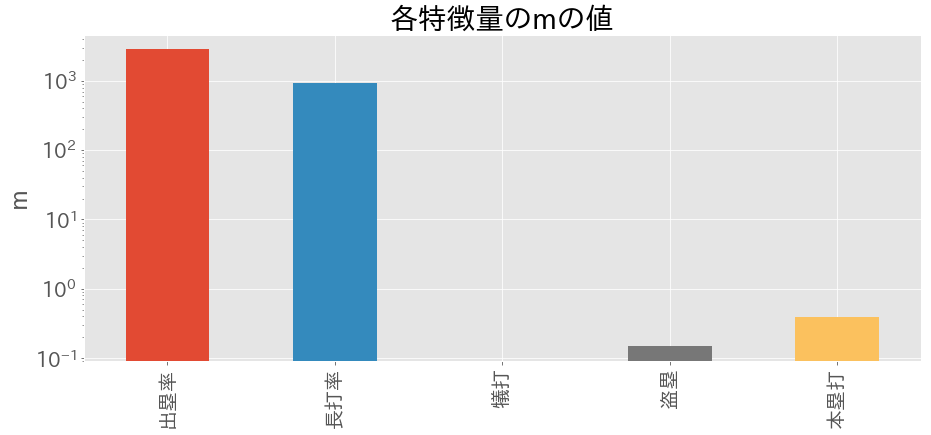

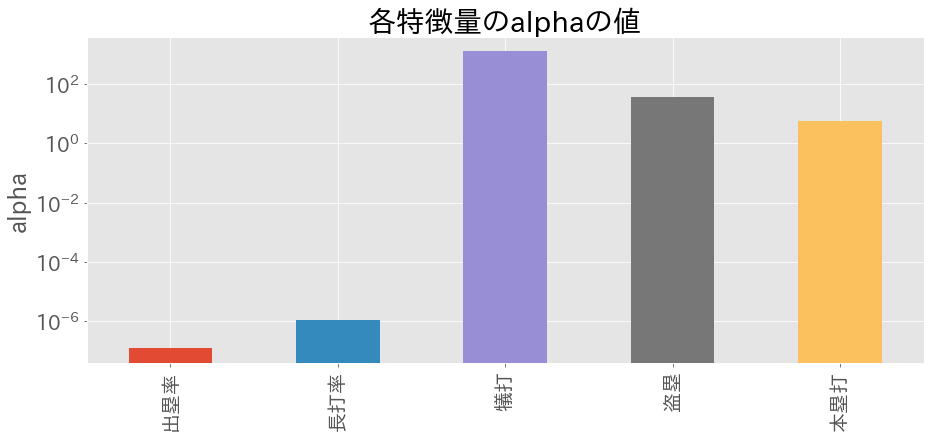

In [12]:
from collections import OrderedDict
df_fet = pd.DataFrame(OrderedDict({'m': model.m[:-1], 'alpha': model.alpha[:-1]}))
df_fet.index = np.array(x_cols)[model.bool_arr_for_pred[:-1]]
df_fet.columns = ['m', 'alpha']

for var in ['m', 'alpha']:
    plt.figure(figsize=(15,6))
    df_fet[var].plot.bar()
    plt.title("各特徴量の"+var+"の値")
    plt.ylabel(var)
    plt.yscale('log')
    plt.show()

# 予測結果

予測精度を見る

In [13]:
y_pred = model.predict(x_test)
rmse(y_pred, y_test)

21.739688524489146

RMSEは21.7という結果になった。  
他の線形回帰と同程度の結果(下記参照)。

In [14]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

alphas = np.logspace(-3, 2, num=30)


for model_obj in [RidgeCV, LassoCV, ElasticNetCV]:
    print("********* model:", model_obj.__name__, "************")
    model_ = model_obj(alphas=alphas)
    model_.fit(x_train, y_train)
    y_pred_ = model_.predict(x_test)

    print("rmse:", rmse(y_pred_, y_test))

    display(pd.DataFrame([model_.coef_], columns=x_cols))

********* model: RidgeCV ************
rmse: 20.93864384740071


,打率,出塁率,長打率,犠打,盗塁,本塁打
0,277.358325,2539.083505,839.93496,-0.092203,0.214686,0.449271


********* model: LassoCV ************
rmse: 21.05123145927037


,打率,出塁率,長打率,犠打,盗塁,本塁打
0,0.0,2877.333916,821.378631,-0.095615,0.207108,0.451416


********* model: ElasticNetCV ************
rmse: 30.10737832183287


,打率,出塁率,長打率,犠打,盗塁,本塁打
0,357.863697,560.165706,492.914888,-0.07368,0.460489,1.113879


RVM予測結果の図示

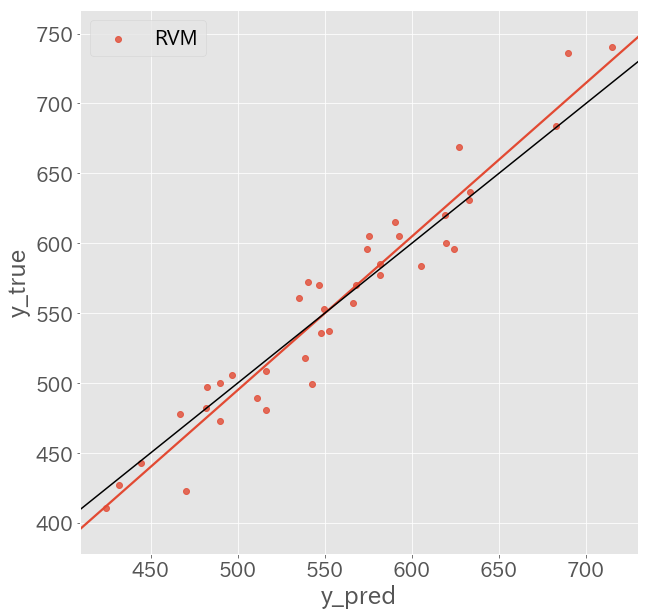

In [15]:
plt.figure(figsize=(10, 10))
ax = sns.regplot('y_pred', 'y_true', pd.DataFrame({"y_true":y_test, "y_pred": y_pred}), ci=None, label='RVM')
ax.legend(loc="best")
plt.plot(np.arange(400, 750), np.arange(400, 750), color='k')

最後に、今シーズンのデータで予測を行ってみた。  

今季はどのチームも、出塁率や長打率の割に効率よく得点出来ている？

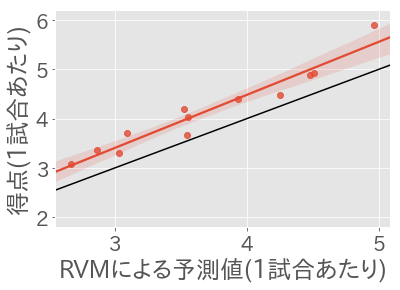

In [16]:
y_pred_2018 = model.predict(df_2018[x_cols])


df_res = pd.DataFrame({"RVMによる予測値(1試合あたり)": y_pred_2018 / 143, "得点(1試合あたり)" : df_2018['得点(1試合あたり)']})

sns.regplot(x='RVMによる予測値(1試合あたり)', y='得点(1試合あたり)', data=df_res)

plt.plot(np.arange(2, 7), np.arange(2, 7), color='k')